In [105]:
from multiprocessing import Process, Value, Array, Lock, Pool, sharedctypes
import time
from sklearn.datasets import make_blobs

In [108]:
zeros = [0]*98
X, y = make_blobs(n_samples=50,
                  n_features=100, centers=[[-5,0]+zeros, [10/2,0]+zeros,
                  [0,10]+zeros, [10,30]+zeros, [50,10]+zeros, [50,20]+zeros, [40,15]+zeros], cluster_std=1, shuffle=True, random_state=100)

In [99]:
def add_100(arr):
    return "hello"


In [59]:
shared_number = Value('i',0, lock=True)
lock = Lock()
p1 = Process(target=add_100, args=(shared_number,))
p2 = Process(target=add_100, args=(shared_number,))
p1.start()
p2.start()
p1.join()
p2.join()

In [70]:
arr.dtype

dtype('float64')

In [100]:
arr = np.array([1,2,3])
ls = [arr]
for i in range (5):
    ls.append(np.array(i*arr))
print(ls)
p = Pool(5)
res = p.map(add_100, ls)

[array([1, 2, 3]), array([0, 0, 0]), array([1, 2, 3]), array([2, 4, 6]), array([3, 6, 9]), array([ 4,  8, 12])]


Process ForkPoolWorker-72:
Process ForkPoolWorker-69:
Process ForkPoolWorker-71:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mstrals/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args,

In [101]:
res

['hello', 'hello', 'hello', 'hello', 'hello', 'hello']

In [60]:
print("number at the end is", shared_number.value)

number at the end is 2000


In [117]:
import math
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition, metrics
from matplotlib import pyplot as plt
from hierarchy import dist, merge, calc_partitions, calc_dists, weighted_ari, fowlkes_mallows_indices, morlini_zani_index
import scipy
from scipy.cluster import hierarchy
from scipy.spatial import distance
import copy
import pickle
from dendrogram_weights import get_dendrogram_weights
from multiprocessing import Pool, Array

def parallel_calc_dists(X, partitions, delta):
    def dist(p, n, d, delta):
        if len(p) == n:
            D_ = np.array([[delta([i],[j]) for i in X] for j in X])
        else:
            newrow_ = np.zeros(n)
            for i in range(len(p)):
                d = delta(X[p[-1]],X[p[i]])
                for j in p[i]:
                    newrow_[j] = d
            newidxs = p[-1]
            for i in newidxs:
                D_[i] = newrow_
                D_[:,i] = newrow_
    with Pool(20) as pool:
        (n,d) = X.shape
        dist_arr = p.map(lambda  p: dist(p, n, d, delta), partitions)
        return dist_arr
def shortened_calc_dist(X, partitions, delta):
    dist_arr = []
    (n,d) = X.shape
    p = partitions[0]
    if len(p) == n:
        D_ = np.array([[delta([i],[j]) for i in X] for j in X])
    else:
        newrow_ = np.zeros(n)
        for i in range(len(p)):
            d = delta(X[p[-1]],X[p[i]])
            for j in p[i]:
                newrow_[j] = d
        newidxs = p[-1]
        for i in newidxs:
            D_[i] = newrow_
            D_[:,i] = newrow_
    dist_arr.append(D_.copy())
    return dist_arr
def q_val_from_qdist(pack):
    (d, n) = pack
    num = 1. / (1. + d)
    num[range(n), range(n)] = 0.
    qval = num / np.sum(num)
    qval = np.maximum(qval, 1e-12)
    return qval
def modified_g_htsne(x_init, labels, iterations=500, random_state=1000, save_name = None):
    DATA_SIZE = len(x_init)
    desired_classes = np.unique(labels)
    
    def perplex_helper(Di, sigma):
        Pi = np.exp(-1*Di.copy() * sigma)
        Psum = np.sum(Pi)
        perp_calc = np.log(Psum) + sigma * np.sum(Di * Pi) / Psum
        Pf = Pi/Psum
        return Pf, perp_calc

    def calc_p_vals(X, tol = 1e-5, perplexity = 30.0):
        (n, d) = X.shape

        partitions, pdist = calc_partitions(X, dist)
        P = [np.zeros((n, n)) for p in partitions]
        sigmas = [np.ones((n,1)) for p in partitions]

        for p in range(len(partitions)):
            for i in range(n):
                scaled_perplexity = perplexity*math.sqrt((n/DATA_SIZE)) #Adjust perplexity based on partiton data size
                pdists = pdist[p]
                Di = pdists[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
                Pf, perp_calc = perplex_helper(Di, sigmas[p][i])
                #perplexity calculation - binary search for best param
                min_ = -np.inf
                max_ = np.inf
                count = 0
                diff = perp_calc - np.log(scaled_perplexity)
                while diff > tol and count < 50:
                    if diff > 0:
                        min_ = sigmas[p][i].copy()
                        if max_ == np.inf or max_ == -np.inf:
                            sigmas[p][i] = sigmas[p][i] * 2.
                        else:
                            sigmas[p][i] = (sigmas[p][i] + max_) / 2.
                    else:
                        max_ = sigmas[p][i].copy()
                        if min_ == np.inf or min_ == -np.inf:
                            sigmas[p][i] = sigmas[p][i] / 2.
                        else:
                            sigmas[p][i] = (sigmas[p][i] + min_) / 2.
                    count+=1
                    Pf, perp_calc = perplex_helper(Di, sigmas[p][i])
                    diff = perp_calc - np.log(scaled_perplexity)

                P[p][i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = Pf
        return P, partitions
    np.random.seed(random_state)
    y = np.random.rand(DATA_SIZE, 2)

    #PCA and normalize into ball of radius 1
    x = decomposition.PCA(n_components=30).fit_transform(x_init)
    x = x/np.var(np.linalg.norm(x, axis=1))

    (n,d) = x.shape

    pvals, partitions = calc_p_vals(x)
    for idx in range(len(pvals)):
        pvals[idx] = pvals[idx] + pvals[idx].T       # calculate symmetric pvals
        pvals[idx] = pvals[idx] / np.sum(pvals[idx])

        #early exaggeration
        pvals[idx] = pvals[idx] * 4.
        pvals[idx] = np.maximum(pvals[idx], 1e-12)

    print("dumping pvals and partitions")
    weights = get_dendrogram_weights(x)[::-1]

    if(save_name is not None):
        with open(save_name + '_pvals', 'wb') as f:
            pickle.dump(pvals, f)
        with open(save_name + '_partition', 'wb') as f:
            pickle.dump(partitions, f)
        with open(save_name + '_weights', 'wb') as f:
            pickle.dump(weights, f)

    dys = [np.zeros((n,2)) for x in range(len(partitions))]
    lr = 50

    # params for van der maaten's momentum magic!
    prev_y = np.zeros((n,2))
    init_momentum = 0.5
    st_momentum = 0.8
    gains = np.ones((n, 2))
    min_gain = 0.01
    eta = 500
    

        

    print('Preprocessing done...\n\n')

    for iter in range(iterations):
        pool = Pool(20)

        #compute qvals for each partition
        qdist_temp = shortened_calc_dist(y, [partitions[0]], dist)[0]
        qdists = [qdist_temp for p in partitions]
        qvals = pool.map(q_val_from_qdist , zip(qdists, len(qdists)*[n]))

        #compute gradient -> computation trick again stolen from van der maaten
        for d in range(len(pvals)):
            PQ = pvals[d] - qvals[d]
            for i in range(n):
                dys[d][i,:] = weights[d]*np.sum(np.tile(PQ[:, i] * num[:, i], (2, 1)).T * (y[i, :] - y), 0)

        # van der maaten's momentum magic
        # if iter < 20:
        #     momentum = init_momentum
        # else:
        #     momentum = st_momentum
        # gains = (gains + 0.2) * ((dy > 0.) != (iy > 0.)) + \
        #         (gains * 0.8) * ((dy > 0.) == (iy > 0.))
        # gains[gains < min_gain] = min_gain
        # iy = momentum * iy - eta * (gains * dy)
        # y = y + iy
        # y = y - np.tile(np.mean(y, 0), (n, 1))

        #our shitty gd implementation
        y = y-lr*sum(dys)

        #print loss value
        if (iter + 1) % 10 == 0:
            L = 0
            for i in range(len(pvals)):
                L += np.sum(pvals[i] * np.log(pvals[i] / qvals[i]))  #KL divergence
            print("Iteration %d: error is %f" % (iter + 1, L))

        #stop early exaggeration
        if iter == int(0 / 5):
            for i in range(len(pvals)):
                pvals[i] = pvals[i]/4

        # if iter % 20 == 0:
        #     plt.figure()
        #     base = {}
        #     for class_ in desired_classes:
        #         base[class_] = []
        #     _dict = copy.deepcopy(base)
        #     for i,row in enumerate(y):
        #         _dict[labels[i]].append(row)
        #     for i in _dict.keys():
        #         plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
        #     plt.legend(desired_classes)
        #     plt.axis('equal')
        #     plt.savefig('diagram/iter'+str(iter))

    print("saving result")
    ari = weighted_ari(x_init, y)
    morlini = morlini_zani_index(x_init, y)

    plt.figure()
    try:
        if(save_name is not None):
            np.save(save_name + '_htsne_data', y)
            np.save(save_name + '_htsne_labels', labels)
            np.save(save_name + 'htsne_data_hd', x_init)
        base = {}
        for class_ in desired_classes:
            base[class_] = []
        _dict = copy.deepcopy(base)
        for i,row in enumerate(y):
            _dict[labels[i]].append(row)
        for i in _dict.keys():
            plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
        plt.legend(desired_classes)
    except Exception as e:
        print(e)
        plt.scatter(y[:,0], y[:,1], alpha=0.2)
    print("Weighted Adjusted Rand Index: {}".format(ari))
    print("Morlini-Zani Index: {}".format(morlini))
    plt.axis('equal')

    plt.figtext(.1, .8, "weighted ARI = {}".format(ari))
    plt.figtext(.1, .6, "Morlini-Zani = {}".format(morlini))
    if (save_name is not None):
        plt.savefig(save_name + '_htsne.png')
    plt.show()


    ########## METRICS #############


    ixds = fowlkes_mallows_indices(x_init, y)
    plt.figure()
    plt.title("fowlkes_mallows_indices")
    plt.plot(list(ixds.keys()), list(ixds.values()))
    if (save_name is not None):
        plt.savefig(save_name + '_fm_idx_htsne.png')
    plt.show()
    return y

#####################################################


dumping pvals and partitions
Preprocessing done...




NameError: name 'num' is not defined

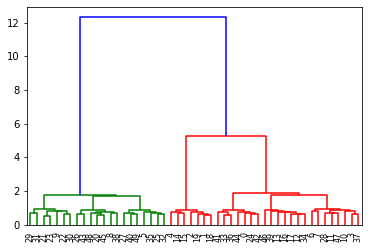

In [118]:
modified_g_htsne(X, y)